In [1]:
%load_ext autoreload
%autoreload 2

In [76]:
import pandas as pd
import numpy as np
import mplfinance as mpf
from matplotlib import pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from arch import arch_model

from src.portfolio_optimization_utils import fit_garch_and_forecast_var

In [3]:
df = pd.read_csv('../data/binance/hbar.csv', parse_dates=['time_stamp'])

In [4]:
df_tmp = df.copy()

In [5]:
df_tmp['return'] = df_tmp['close'].pct_change()

<Axes: >

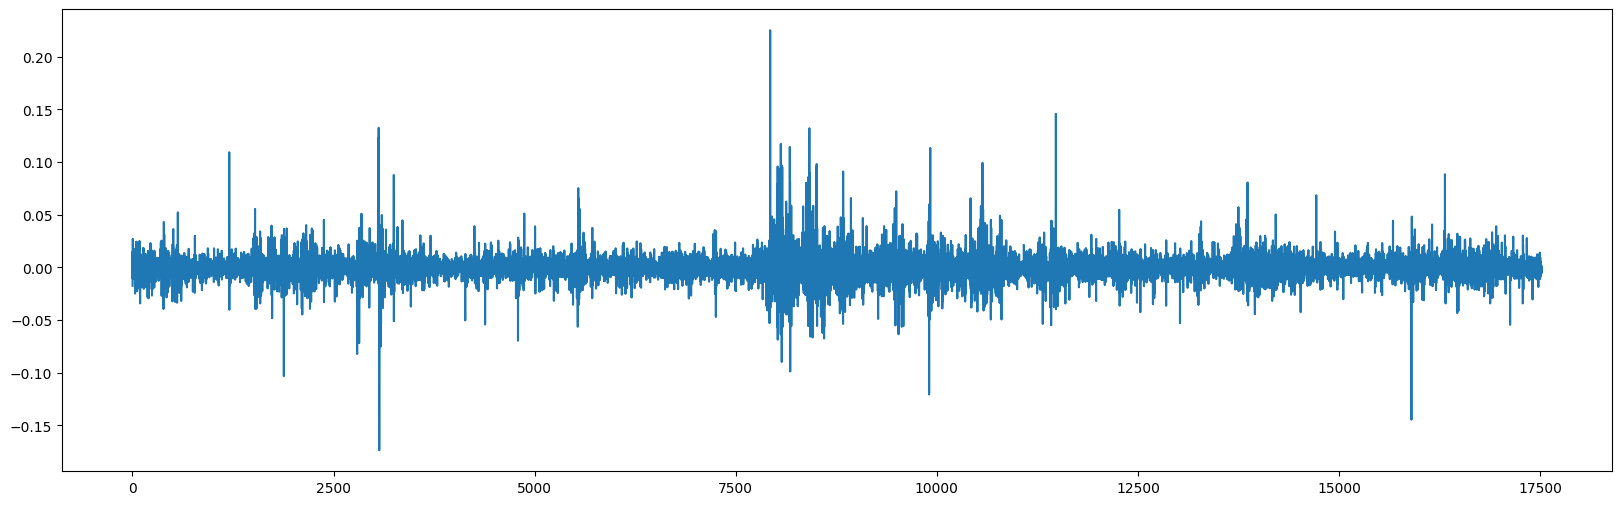

In [6]:
df_tmp['return'].plot(figsize=(20, 6))

In [27]:
df_tmp['volatility_24'] = df_tmp['return'].rolling(window=24).std() * np.sqrt(24)

<Axes: >

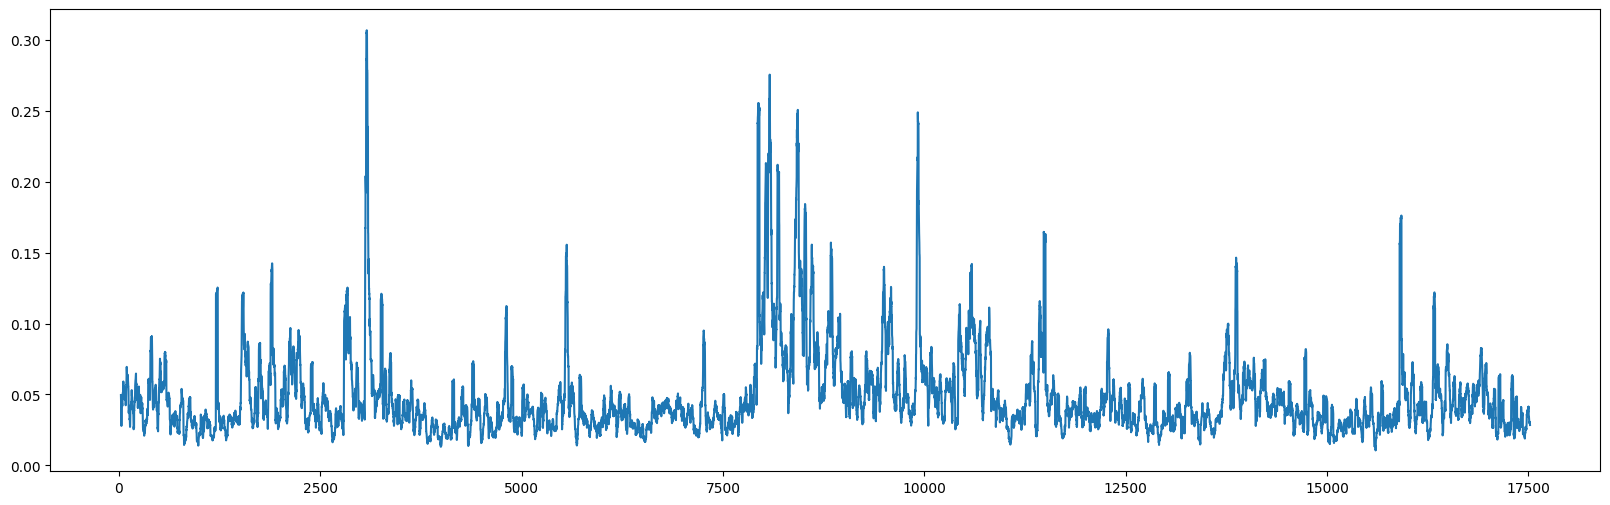

In [28]:
df_tmp.volatility_24.plot(figsize=(20, 6))

In [18]:
returns = pd.DataFrame(df_tmp[['return']]).dropna()*100

In [47]:
am = arch_model(returns, 
                mean = 'AR', 
                lags = 1, 
                vol = 'EGARCH', # EGARCH, HARCH, FIGARCH, ARCH, ConstantVariance
                p = 1, 
                q = 2, 
                o = 1,
                dist = 'skewt')

In [48]:
result = am.fit(disp='off')

In [49]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                AR - EGARCH Model Results                                
=========================================================================================
Dep. Variable:                            return   R-squared:                      -0.002
Mean Model:                                   AR   Adj. R-squared:                 -0.002
Vol Model:                                EGARCH   Log-Likelihood:               -22921.7
Distribution:      Standardized Skew Student's t   AIC:                           45861.3
Method:                       Maximum Likelihood   BIC:                           45931.3
                                                   No. Observations:                17518
Date:                           Thu, Dec 18 2025   Df Residuals:                    17516
Time:                                   11:00:19   Df Model:                            2
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
Const      -8.6146e-03  5.970e-03     -1.443      0.149  [-2.031e-02,3.086e-03]
return[1]      -0.0485  7.964e-03     -6.088  1.140e-09 [-6.410e-02,-3.288e-02]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega          0.0157  3.084e-03      5.096  3.466e-07   [9.673e-03,2.176e-02]
alpha[1]       0.2975  1.926e-02     15.444  8.285e-54       [  0.260,  0.335]
gamma[1]      -0.0166  7.652e-03     -2.173  2.977e-02 [-3.163e-02,-1.631e-03]
beta[1]        0.5995  4.285e-02     13.991  1.769e-44       [  0.516,  0.683]
beta[2]        0.3711  4.315e-02      8.600  7.985e-18       [  0.286,  0.456]
                                 Distribution                                
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
eta            4.8395      0.180     26.890 2.852e-159      [  4.487,  5.192]
lambda         0.0199  1.048e-02      1.893  5.830e-02 [-6.977e-04,4.040e-02]
=============================================================================

Covariance estimator: robust
"""

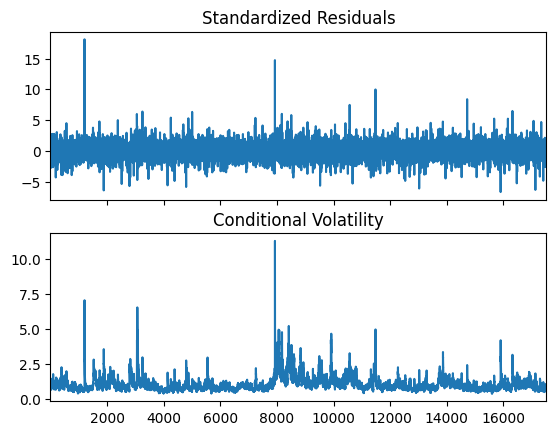

In [50]:
result.plot();

In [69]:
standardized_resids = (result.resid / result.conditional_volatility).dropna()  

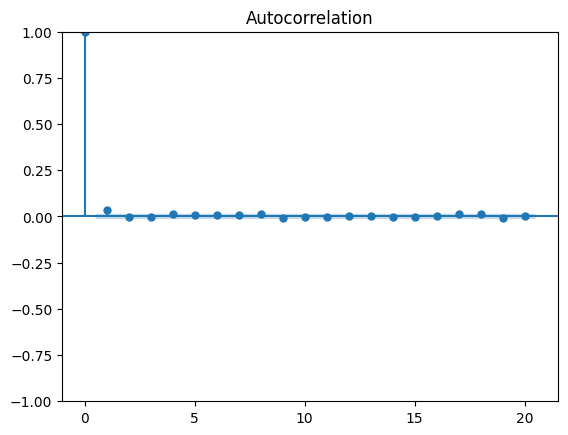

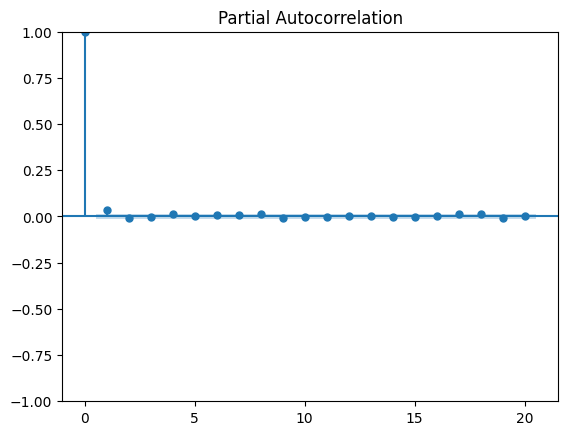

In [71]:
plot_acf(standardized_resids, alpha = 0.05, lags=20);
plot_pacf(standardized_resids, alpha = 0.05, lags=20);

count    17518.000000
mean         0.006549
std          1.011341
min         -6.693632
25%         -0.567766
50%         -0.001261
75%          0.562697
max         18.118193
dtype: float64


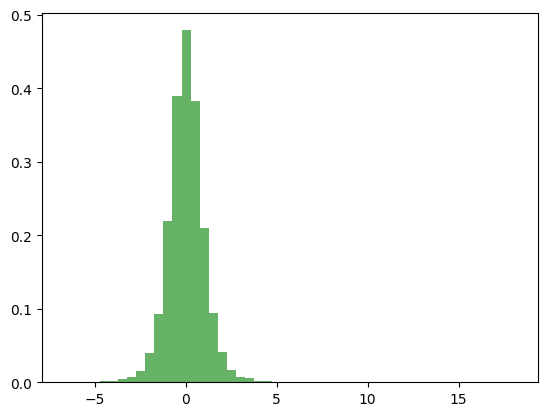

In [ ]:
print(standardized_resids.describe())
plt.hist(standardized_resids, bins=50, density=True, alpha=0.6, color='g')
plt.show()

In [77]:
lb_test = acorr_ljungbox(standardized_resids, lags=[10], return_df=True)
print('p-value:', lb_test['lb_pvalue'].values[0])

p-value: 0.0008709536546738585


In [73]:
result.forecast(horizon=1).variance[-1:]

,h.1
17519,0.416055
